# Create SWI2 model of Experiment 2 from Werner et al. 2009

The paper can be found here:
http://www.sciencedirect.com/science/article/pii/S0022169409002807

In [1]:
%matplotlib inline
import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import flopy

In [2]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement
exepth = os.path.join('..', 'autotest', 'temp')
exe_name = 'mf2005_1.12.00'
mfexe = os.path.abspath(os.path.join(exepth, exe_name))
#mfexe = 'mf2005'

modelpth = os.path.join('..', 'test-dev', 'werner2')
modelname = 'werner2'
#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)

#### Set up elevations of key variables

1. z0sw is the initial height of saltwater above the base of the model
2. zw is the height of the well above the initial height of saltwater
3. h0 is the initial water table height above the initial height of saltwater

In [3]:
z0sw = 0.15
zw = z0sw + 0.4
h0 = z0sw + 0.95
xlen, zlen = 1.075 / 2., h0

aqb = h0
wb0 = zw - z0sw
fwb = h0 - z0sw
swb = z0sw

#### Create Vertical discretization

In [4]:
nv = 6 # 6 works the best
nv2 = 1 # 1 works the best
if nv > 1:
    s0 = np.linspace(zlen, zw, num=nv)
else:
    s0 = np.array([h0, zw])
dz0 = (s0[-1] - z0sw) / float(nv2)
s1 = np.linspace(zw-dz0, z0sw, num=nv2)
botm = np.append(s0, s1)
botm = np.append(botm, 0.)

#### Specify the number of layers, rows, and columns

In [5]:
nlay, nrow, ncol = botm.shape[0]-1, 1, 1000
print('nlay: {}, nrow{}, ncol: {}'.format(nlay, nrow, ncol))

nlay: 7, nrow1, ncol: 1000


#### Specify the timestep information and conversion factor for 

In [6]:
min2day = 60. * 24.
perlen, nstp, tsmult = 350. / min2day , 200, 1.0

#### Calculate the length along rows (dx) and columns (delc).

In [7]:
dx = xlen / float(ncol)
delc = 0.053

#### Specify model parameters

Set ibound with constant stage on edges and hydraulic properties

In [8]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
ibound[:, :, 0] = -1

hk = 140. # m/d / 86400. # m/s
ss = 1.e-5
porosity = 0.38

#### Find the position of the well

In [9]:
Q = -(3.8e-6 / 2.) * 86400. # m3/s
# find position of well
iposw = 0
for k in range(nlay):
    if zw < botm[k+1]:
        iposw = k
print('The well is located in layer {}'.format(iposw+1))

The well is located in layer 4


#### Create well data

In [10]:
# boundary condition data
# well data
nwells = 1
lrcq = np.zeros((nwells, 4))
lrcq[0, 0] = iposw    
lrcq[0, 1] = 0
lrcq[0, 2] = ncol - 1
lrcq[0, 3] = Q
# create well dictionary
well_data = {0:lrcq}


#### Create SWI data

In [11]:
# swi2 data
reldrho = 0.025
nu = [0., reldrho]
numult = 5.
toeslope = nu[1] / numult  #0.005
tipslope = nu[1] / numult  #0.005
z = [z0sw]
iso = np.zeros((nlay, nrow, ncol), dtype=np.int)
iso[:, 0, 0] = -1
iso[-1, 0, 0] = 2
# swi2 observations
obsnam = []
obslrc = []
for k in range(iposw, nlay):
    obsnam.append('layer{}_'.format(k+1))
    obslrc.append([k, 0, ncol-1])
nobs = len(obsnam)
iswiobs = 1051
print(obslrc)


[[3, 0, 999], [4, 0, 999], [5, 0, 999], [6, 0, 999]]


#### Create the model objects

In [12]:
ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=mfexe, model_ws=modelpth)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                        delr=dx, delc=delc, top=botm[0], botm=botm[1:],
                        nper=1, perlen=perlen, nstp=nstp, tsmult=tsmult, steady=False,
                                  itmuni=4, lenuni=2)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=h0)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=1, hk=hk, vka=hk, sy=porosity, ss=ss)
wel = flopy.modflow.ModflowWel(ml, stress_period_data=well_data)
swi = flopy.modflow.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=toeslope, tipslope=tipslope, nu=nu,
                     zeta=z, ssz=porosity, isource=iso, nsolver=1,
                     nobs=nobs, iswiobs=iswiobs, obsnam=obsnam, obslrc=obslrc)
oc = flopy.modflow.ModflowOc(ml, stress_period_data={(0,0):['print budget', 'save head']})
de4 = flopy.modflow.ModflowDe4(ml)

2 12 (4, 3)


/Users/jdhughes/Documents/Development/flopy_git/flopy/modflow/mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")


#### Write the model files and run the model

In [13]:
ml.write_input()
ml.run_model(silent=True)

(True, [])

#### Load the model results


Load the simulation 1 `ZETA` data and `ZETA` observations.

In [14]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
kstpkper = zfile.get_kstpkper()
hfile = flopy.utils.HeadFile(os.path.join(ml.model_ws, modelname+'.hds'))
totim = hfile.get_times()
t = np.array(totim) * 86400.
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)
print(zeta.shape)
# read swi obs
zobs = np.genfromtxt(os.path.join(ml.model_ws, modelname+'.zobs'), names=True)
print(zobs.dtype)

(200, 7, 1, 1000)
[('TOTIM', '<f8'), ('layer4_001', '<f8'), ('layer5_001', '<f8'), ('layer6_001', '<f8'), ('layer7_001', '<f8')]


#### Create a time series of observed zeta surface

In [15]:
zc = np.zeros((zobs['TOTIM'].shape[0]), dtype=np.float)
for idx, tt in enumerate(zobs['TOTIM']):
    for k in range(iposw, nlay):
        key = 'layer{}_001'.format(k+1)
        zt = zobs[key][idx]
        if zt < botm[k] and zt > botm[k+1]:
            zc[idx] = zt
            break

#### Function to calculate non-dimensional time

In [17]:
def calcTp(nu, Kh, Kv, n, d):
    uf = 1.002e-3
    us = 1.080e-3
    rhof = 1000.
    rhos = (1. + nu) * rhof
    drho = rhos - rhof
    g = 9.80665
    dgamma = g * drho    
    kh = (Kh / 86400.) * uf / (rhof * g)
    kv = (Kv / 86400.) * uf / (rhof * g) 
    betaf = n * uf / (np.sqrt(kh*kv) * dgamma)
    betas = n * us / (np.sqrt(kh*kv) * dgamma)
    return t / ((betaf + betas) * d)

#### Function to calculate non-dimensional interface elevation

In [18]:
def calcZ(a, d, x, Tp):
    X = x / a
    D = d / a
    Z = (1. / (2. * np.pi)) * np.log(((X / D)**2 + (Tp + 1)**2) / ((X / D)**2 + 1))
    return Z

#### Function to calculate interface elevation from non-dimensional interface elevation

In [19]:
def Z2zeta(nu, Kh, Kv, Q, w, Z, b=0.):
    Q /= -w * 86400.
    uf = 1.002e-3
    us = 1.080e-3
    rhof = 1000.
    rhos = (1. + nu) * rhof
    drho = rhos - rhof
    g = 9.80665
    dgamma = g * drho    
    kh = (Kh / 86400.) * uf / (rhof * g)
    kv = (Kv / 86400.) * uf / (rhof * g)  
    zeta = Q * Z * uf / (np.sqrt(kh*kv) * dgamma) 
    return zeta + b    

#### Function to calculate interface elevation

From Dagan and Bear (1968)

In [20]:
def eq49(nu, Kh, Kv, n, Q, w, t, d, x, b=0.):
    Q /= -w * 86400.
    uf = 1.002e-3
    us = 1.080e-3
    rhof = 1000.
    rhos = (1. + nu) * rhof
    drho = rhos - rhof
    g = 9.80665
    dgamma = g * drho    
    nufus = n * (uf + us)
    kh = (Kh / 86400.) * uf / (rhof * g)
    kv = (Kv / 86400.) * uf / (rhof * g)
    zeta = (uf * Q / (2. * np.pi * dgamma * np.sqrt(kh * kv))) * \
        np.log(((kv/kh)**2. * x**2. + (kv * dgamma * t / nufus + d)**2.) / ((kv/kh)**2. * x**2. + d**2.))
    return zeta + b

#### Calculate analytical interface elevation

Compare analytical interface elevation and simulated interface at the well position.

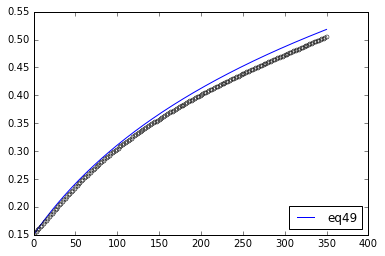

In [21]:
zval = eq49(reldrho, hk, hk, porosity, Q, delc, t, wb0, 0, b=z0sw)
plt.plot(t/60., zval, label='eq49')
plt.plot(t/60., zc, marker='o', lw=0, ms=4, mfc='none', mec='black')
plt.legend(loc='lower right')

#### Define figure dimensions and colors used for plotting `ZETA` surfaces

In [22]:
# figure dimensions
fwid, fhgt = 8., 5.5
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925

# line color definition
icolor = 15
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

#### Plot simulated and analytical interface elevations

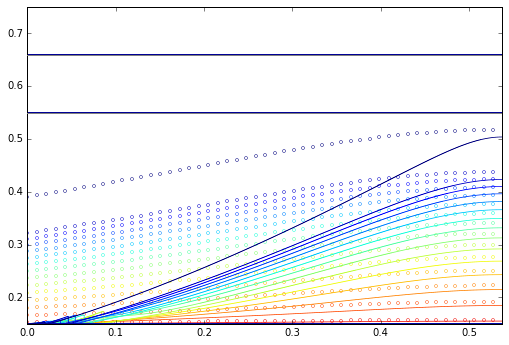

In [23]:
plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(fwid, fhgt), facecolor='w')
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)
# first plot
ax = fig.add_subplot(1, 1, 1)
# axes limits
ax.set_xlim(0., xlen)
ax.set_ylim(0.15, 0.75)
itim = 1
for idx in range(icolor):
    if idx+1 == icolor:
        itim = -1
    Tp = calcTp(reldrho, hk, hk, porosity, zw-z0sw)
    for k in range(nlay):
        #zv = zeta[itim, k, 0, :]
        ax.plot(ml.sr.xcenter, zeta[itim, k, 0, :], drawstyle='steps-mid', 
                linewidth=0.75, color=cc[idx], label='{:5.2g} min'.format(totim[itim]*min2day))
    Z = calcZ(h0-z0sw, zw-z0sw, ml.sr.xcenter, Tp[itim])
    ztt = Z2zeta(reldrho, hk, hk, Q, delc, Z, b=z0sw)
    #print(ztt)
    ax.plot(ml.sr.xcenter, ztt[::-1], marker='o', lw=0, mfc='none', mec=cc[idx], markevery=20, ms=3)
    itim += 10
for k in range(nlay):
    ax.plot([0, xlen], [botm[k+1], botm[k+1]], lw=1, color='0.5', zorder=10)